In [1]:
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd

import snowflake.connector
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [4]:
c = SSMPSCredentials('datascience-max-dev-sagemaker-notebooks')

In [7]:
c.get_keys()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


{'ARN': 'arn:aws:secretsmanager:us-east-1:613630599026:secret:datascience-max-dev-sagemaker-notebooks-6P450a',
 'Name': 'datascience-max-dev-sagemaker-notebooks',
 'VersionId': 'c7acdf78-4842-4a9e-840b-9823979d9ceb',
 'SecretString': '{"login_name":"max.glue.dev","login_password":"2p6R3teB8wm@9G","warehouse":"MAX_DATASCIENCE_DEV","role":"MAX_GLUE_DEV","snowflake_url":"https://hbomax.us-east-1.snowflakecomputing.com/","account":"hbomax.us-east-1"}',
 'VersionStages': ['AWSCURRENT'],
 'CreatedDate': datetime.datetime(2021, 3, 24, 5, 43, 21, 52000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'f5961232-c960-4c20-98e3-db5942a96074',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f5961232-c960-4c20-98e3-db5942a96074',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '528',
   'date': 'Wed, 13 Mar 2024 21:35:24 GMT'},
  'RetryAttempts': 0}}

In [2]:
## WRITE OR READ FROM S3 ####
import boto3
import io

s3 = boto3.resource('s3')
output_bucket = "hbo-outbound-datascience-content-dev"
input_bucket = "hbo-ingest-datascience-content-dev"
bucket = s3.Bucket(input_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
def write_to_input(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=input_bucket, Key=filename, Body=content)
    
def read_from_s3(filename, input_bucket = input_bucket):
    for obj in bucket.objects.filter(Prefix='title_hours_viewed_retention/'+filename): #churn_metric_0811
            key = obj.key 
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            df = pd.read_csv(body, na_values = [r'\\\\N'])
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
data = read_from_s3('Cannibalization Analysis.csv')
data_ca_title = read_from_s3('cannibalization_analysis_detailed_view.csv')

Reading title_hours_viewed_retention/Cannibalization Analysis.csv.csv features
Reading title_hours_viewed_retention/cannibalization_analysis_detailed_view.csv.csv features


# Causal

In [5]:
!pip install cdt
!pip install torch

     |████████████████████████████████| 921 kB 20.2 MB/s            
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=042a568c37257a5ccf27b98195eea03cdd928dc711e620f5cc0ee0eb3dfd0324
  Stored in directory: /home/ec2-user/.cache/pip/wheels/79/c1/b2/b6fc2647f693a084da25e1d31328ab3dbb565cc58fea37e973
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29256 sha256=35879856efa3a098631eb820ebf50e6591711ff992ed288560bc1de3a1de15f3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/86/52/36/f89dbee69f4529cd18215e030111c80b743b84205ea75f7df6
Successfully built GPUtil skrebate
     |████████████████████████████████| 881.9 MB 7.7 kB/s              


In [6]:
import cdt
import networkx as nx
import matplotlib.pyplot as plt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
Matplotlib is building the font cache; this may take a moment.


In [7]:
data['medal_number'] = data['medal_number'].fillna(3)

In [8]:
df = data[['ahvr', 'medal_Platinum_count', 'medal_same_count', 'medal_number']]

In [9]:
df_msc_avg = df.groupby(['medal_number'])['medal_same_count'].mean().reset_index().rename(columns = {'medal_same_count':'medal_same_count_avg'})
df = df.merge(df_msc_avg, on = ['medal_number'])
df['medal_same_count_bigger_than_average'] = 0
df.loc[df['medal_same_count'] > df['medal_same_count_avg'], 'medal_same_count_bigger_than_average'] = 1

In [10]:
df_msc_avg = df.groupby(['medal_number'])['medal_Platinum_count'].mean().reset_index().rename(columns = {'medal_Platinum_count':'medal_Platinum_count_avg'})
df = df.merge(df_msc_avg, on = ['medal_number'])
df['medal_Platinum_count_bigger_than_average'] = 0
df.loc[df['medal_Platinum_count'] > df['medal_Platinum_count_avg'], 'medal_Platinum_count_bigger_than_average'] = 1

In [11]:
# ### Setting different threshold
# df['medal_Platinum_count_avg'] = 0.98
# df['medal_Platinum_count_bigger_than_average'] = 0
# df.loc[df['medal_Platinum_count'] > df['medal_Platinum_count_avg'], 'medal_Platinum_count_bigger_than_average'] = 1

In [12]:
df.tail()

,ahvr,medal_Platinum_count,medal_same_count,medal_number,medal_same_count_avg,medal_same_count_bigger_than_average,medal_Platinum_count_avg,medal_Platinum_count_bigger_than_average
3689,0.22,1,1,0.00,1.84,0,1.84,0
3690,0.34,2,2,0.00,1.84,1,1.84,1
3691,0.19,1,1,0.00,1.84,0,1.84,0
3692,0.39,1,1,0.00,1.84,0,1.84,0
3693,0.31,3,3,0.00,1.84,1,1.84,1


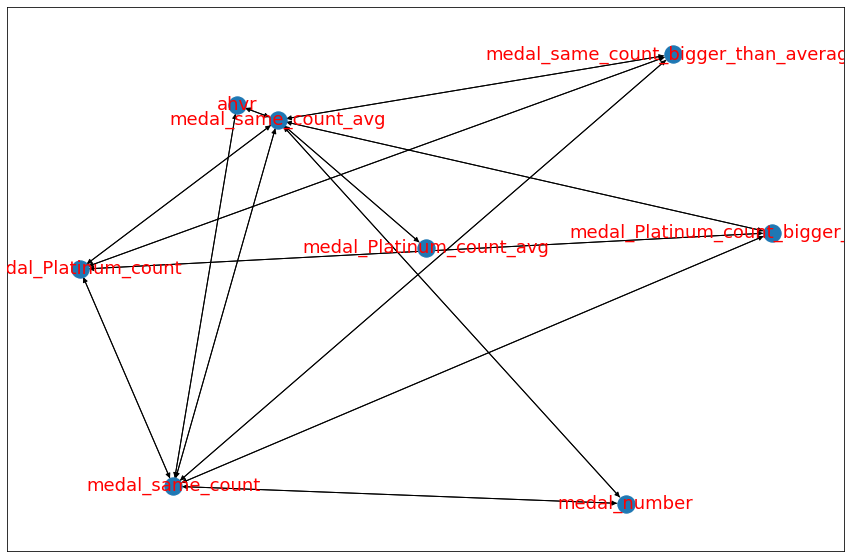

In [13]:
# Get skeleton graph
# initialize graph lasso
glasso = cdt.independence.graph.Glasso()
# apply graph lasso to data
skeleton = glasso.predict(df)
# visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

In [14]:
# # Use causal discovery to get causal models
# # PC algorithm
# model_pc = cdt.causality.graph.PC()
# graph_pc = model_pc.predict(df, skeleton)

# # visualize network
# fig=plt.figure(figsize=(15,10))
# nx.draw_networkx(graph_pc, font_size=18, font_color='r')

In [15]:
!pip install econml
!pip install dowhy

     |████████████████████████████████| 1.4 MB 20.7 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 77 kB 6.8 MB/s             
     |████████████████████████████████| 1.7 MB 76.0 MB/s            
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /home/ec2-user/anaconda3/envs/python3/bin/python /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pip install --ignore-installed --no-user --prefix /tmp/pip-build-env-tn0hzivm/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'scikit-build-core>=0.4.4'
       cwd: None
  Complete output (2 lines):
  ERROR: Could not find a version that satisfies the requirement scikit-build-core>=0.4.4 (from versions: none)
  ERROR: No matching distribution found for scikit-build-core>=0.4.4
  ---

In [16]:
import econml
import dowhy
from dowhy import CausalModel

In [17]:
df.columns

Index(['ahvr', 'medal_Platinum_count', 'medal_same_count', 'medal_number',
       'medal_same_count_avg', 'medal_same_count_bigger_than_average',
       'medal_Platinum_count_avg', 'medal_Platinum_count_bigger_than_average'],
      dtype='object')

In [18]:
G = nx.DiGraph()
G.add_nodes_from(['ahvr', 'medal_Platinum_count', 'medal_same_count', 'medal_number'])
G.add_edges_from([
                  ("medal_number", "ahvr"), 
                  ("medal_number", "medal_same_count"), 
                  ("medal_number", "medal_Platinum_count"), 
                  ("medal_same_count", "medal_same_count_bigger_than_average"), 
                  ("medal_Platinum_count", "medal_Platinum_count_bigger_than_average"), 
                  ("medal_same_count_bigger_than_average", "ahvr"), 
                  ("medal_Platinum_count_bigger_than_average", "ahvr")
                ])
# G.add_edges_from([
#                   ("medal_number", "ahvr"), 
# #                   ("medal_number", "medal_same_count"), 
# #                   ("medal_number", "medal_Platinum_count"), 
# #                   ("medal_same_count", "medal_same_count_bigger_than_average"), 
# #                   ("medal_Platinum_count", "medal_Platinum_count_bigger_than_average"), 
#                   ("medal_same_count_bigger_than_average", "ahvr"), 
#                   ("medal_Platinum_count_bigger_than_average", "ahvr")
#                 ])

In [19]:
graph = nx.generate_gml(G)
graph = ''.join(graph)

In [20]:
# With graph
model=CausalModel(
        data = df,
        treatment="medal_Platinum_count_bigger_than_average",
        outcome="ahvr",
        graph = graph
        )

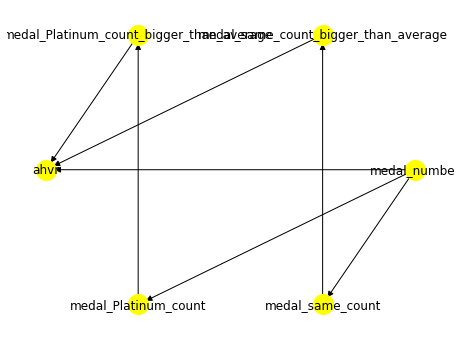

In [21]:
model.view_model() 

In [22]:
# Generate estimand
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                     
───────────────────────────────────────────(Expectation(ahvr|medal_number))
d[medal_Platinum_count_bigger_than_average]                                
Estimand assumption 1, Unconfoundedness: If U→{medal_Platinum_count_bigger_than_average} and U→ahvr then P(ahvr|medal_Platinum_count_bigger_than_average,medal_number,U) = P(ahvr|medal_Platinum_count_bigger_than_average,medal_number)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Compute causal effect using metalearner
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TweedieRegressor

metalearner_estimate = model.estimate_effect(identified_estimand_experiment,                             
                                             method_name="backdoor.econml.metalearners.TLearner",
                                             confidence_intervals=False,
                                             method_params={
                                                         "init_params":{'models': RandomForestRegressor()},
                                                         "fit_params":{}
                                                                  })
print(metalearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                     
───────────────────────────────────────────(Expectation(ahvr|medal_number))
d[medal_Platinum_count_bigger_than_average]                                
Estimand assumption 1, Unconfoundedness: If U→{medal_Platinum_count_bigger_than_average} and U→ahvr then P(ahvr|medal_Platinum_count_bigger_than_average,medal_number,U) = P(ahvr|medal_Platinum_count_bigger_than_average,medal_number)

## Realized estimand
b: ahvr~medal_Platinum_count_bigger_than_average+medal_same_count+medal_same_count_bigger_than_average+medal_number
Target units: ate

## Estimate
Mean value: 0.003590854582938929
Effect estimates: [ 0.00154044 -0.00032926 -0.00137404 ...  0.1578794   0.1578794
  0.04347971]



(array([2.200e+01, 5.130e+02, 3.089e+03, 1.000e+00, 3.400e+01, 7.000e+00,
        0.000e+00, 7.000e+00, 0.000e+00, 2.100e+01]),
 array([-0.04501192, -0.02349891, -0.0019859 ,  0.01952712,  0.04104013,
         0.06255314,  0.08406615,  0.10557917,  0.12709218,  0.14860519,
         0.17011821]),
 <BarContainer object of 10 artists>)

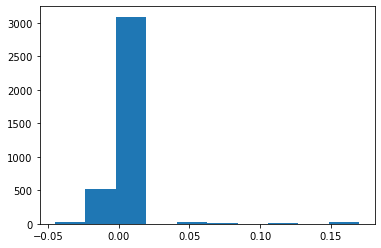

In [25]:
# Print histogram of causal effects
plt.hist(metalearner_estimate.cate_estimates)

## By Tier

### Platinum

In [26]:
# With graph
model=CausalModel(
        data = df[df['medal_number'] == 0],
        treatment="medal_Platinum_count_bigger_than_average",
        outcome="ahvr",
        graph = graph
        )

In [27]:
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

metalearner_estimate = model.estimate_effect(identified_estimand_experiment,                             
                                             method_name="backdoor.econml.metalearners.TLearner",
                                             confidence_intervals=False,
                                             method_params={
                                                         "init_params":{'models': TweedieRegressor()},
                                                         "fit_params":{}
                                                                  })
print(metalearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                     
───────────────────────────────────────────(Expectation(ahvr|medal_number))
d[medal_Platinum_count_bigger_than_average]                                
Estimand assumption 1, Unconfoundedness: If U→{medal_Platinum_count_bigger_than_average} and U→ahvr then P(ahvr|medal_Platinum_count_bigger_than_average,medal_number,U) = P(ahvr|medal_Platinum_count_bigger_than_average,medal_number)

## Realized estimand
b: ahvr~medal_Platinum_count_bigger_than_average+medal_same_count+medal_same_count_bigger_than_average+medal_number
Target units: ate

## Estimate
Mean value: 0.1314124035511143
Effect estimates: [0.12784543 0.12784543 0.15014781 0.12784543 0.12784543 0.12784543
 0.08322662 0.10553602 0.15014781 0.12784543 0.12784543 0.12784543
 0.15014781 0.12784543 0.12784543 0.1278454

(array([ 1.,  0.,  0.,  3.,  0.,  0., 12.,  0.,  0.,  9.]),
 array([0.08322662, 0.08991874, 0.09661086, 0.10330298, 0.1099951 ,
        0.11668721, 0.12337933, 0.13007145, 0.13676357, 0.14345569,
        0.15014781]),
 <BarContainer object of 10 artists>)

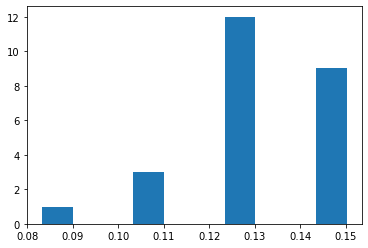

In [28]:
# Print histogram of causal effects
plt.hist(metalearner_estimate.cate_estimates)

### Gold

In [37]:
df_gold = df[df['medal_number'] == 1]
# df_gold['medal_same_count_avg'] = 3 # 2.78
df_gold['medal_Platinum_count_bigger_than_average'] = 0
df_gold.loc[df_gold['medal_Platinum_count'] > df_gold['medal_Platinum_count_avg'], 'medal_Platinum_count_bigger_than_average'] = 1

In [38]:
df_gold.head()

,ahvr,medal_Platinum_count,medal_same_count,medal_number,medal_same_count_avg,medal_same_count_bigger_than_average,medal_Platinum_count_avg,medal_Platinum_count_bigger_than_average
3564,0.04,1,3,1.00,2.78,1,0.84,1
3565,0.05,0,2,1.00,2.78,0,0.84,0
3566,0.01,1,1,1.00,2.78,0,0.84,1
3567,0.08,1,3,1.00,2.78,1,0.84,1
3568,0.06,0,3,1.00,2.78,1,0.84,0


In [39]:
# With graph
model=CausalModel(
        data = df_gold,
        treatment="medal_Platinum_count_bigger_than_average",
        outcome="ahvr",
        graph = graph
        )

In [40]:
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

metalearner_estimate = model.estimate_effect(identified_estimand_experiment,                             
                                             method_name="backdoor.econml.metalearners.TLearner",
                                             confidence_intervals=False,
                                             method_params={
                                                         "init_params":{'models': RandomForestRegressor()},
                                                         "fit_params":{}
                                                                  })
print(metalearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                     
───────────────────────────────────────────(Expectation(ahvr|medal_number))
d[medal_Platinum_count_bigger_than_average]                                
Estimand assumption 1, Unconfoundedness: If U→{medal_Platinum_count_bigger_than_average} and U→ahvr then P(ahvr|medal_Platinum_count_bigger_than_average,medal_number,U) = P(ahvr|medal_Platinum_count_bigger_than_average,medal_number)

## Realized estimand
b: ahvr~medal_Platinum_count_bigger_than_average+medal_same_count+medal_same_count_bigger_than_average+medal_number
Target units: ate

## Estimate
Mean value: -0.01584779420263739
Effect estimates: [-0.04463599  0.01293665 -0.00337205 -0.04463599 -0.04463599 -0.00337205
  0.01293665 -0.02153818  0.01293665 -0.00337205 -0.00337205 -0.02153818
 -0.04463599  0.00657615  0.0

### Silver

In [43]:
# With graph
model=CausalModel(
        data = df[df['medal_number'] == 2],
        treatment="medal_Platinum_count_bigger_than_average",
        outcome="ahvr",
        graph = graph
        )

In [45]:
df[df['medal_number'] == 2].head()

,ahvr,medal_Platinum_count,medal_same_count,medal_number,medal_same_count_avg,medal_same_count_bigger_than_average,medal_Platinum_count_avg,medal_Platinum_count_bigger_than_average
3609,0.04,1,1,2.00,3.75,0,0.98,1
3610,0.01,0,7,2.00,3.75,1,0.98,0
3611,0.00,1,4,2.00,3.75,1,0.98,1
3612,0.05,0,5,2.00,3.75,1,0.98,0
3613,0.04,1,6,2.00,3.75,1,0.98,1


In [44]:
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

metalearner_estimate = model.estimate_effect(identified_estimand_experiment,                             
                                             method_name="backdoor.econml.metalearners.TLearner",
                                             confidence_intervals=False,
                                             method_params={
                                                         "init_params":{'models': RandomForestRegressor()},
                                                         "fit_params":{}
                                                                  })
print(metalearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                     
───────────────────────────────────────────(Expectation(ahvr|medal_number))
d[medal_Platinum_count_bigger_than_average]                                
Estimand assumption 1, Unconfoundedness: If U→{medal_Platinum_count_bigger_than_average} and U→ahvr then P(ahvr|medal_Platinum_count_bigger_than_average,medal_number,U) = P(ahvr|medal_Platinum_count_bigger_than_average,medal_number)

## Realized estimand
b: ahvr~medal_Platinum_count_bigger_than_average+medal_same_count+medal_same_count_bigger_than_average+medal_number
Target units: ate

## Estimate
Mean value: 0.03137812734647393
Effect estimates: [-0.00469058  0.05689961  0.0397885   0.00932569  0.07172062  0.03902206
  0.00932569  0.00932569  0.01779245  0.01779245  0.0397885   0.03902206
  0.01779245 -0.00469058  0.03

### Bronze

In [50]:
# With graph
model=CausalModel(
        data = df[df['medal_number'] >= 2],
        treatment="medal_Platinum_count_bigger_than_average",
        outcome="ahvr",
        graph = graph
        )

In [51]:
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

metalearner_estimate = model.estimate_effect(identified_estimand_experiment,                             
                                             method_name="backdoor.econml.metalearners.TLearner",
                                             confidence_intervals=False,
                                             method_params={
                                                         "init_params":{'models': RandomForestRegressor()},
                                                         "fit_params":{}
                                                                  })
print(metalearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                     d                                                     
───────────────────────────────────────────(Expectation(ahvr|medal_number))
d[medal_Platinum_count_bigger_than_average]                                
Estimand assumption 1, Unconfoundedness: If U→{medal_Platinum_count_bigger_than_average} and U→ahvr then P(ahvr|medal_Platinum_count_bigger_than_average,medal_number,U) = P(ahvr|medal_Platinum_count_bigger_than_average,medal_number)

## Realized estimand
b: ahvr~medal_Platinum_count_bigger_than_average+medal_same_count+medal_same_count_bigger_than_average+medal_number
Target units: ate

## Estimate
Mean value: 0.002920918522909215
Effect estimates: [ 0.00162334 -0.00061614 -0.00110981 ...  0.04644892 -0.00457799
  0.03860715]



In [223]:
# !pip install causalinference

In [224]:
from causalinference import CausalModel
from causalinference.utils import random_data
#Y is the outcome, D is treatment status, and X is the independent variable
causal = CausalModel(df['ahvr'], 
                     df['medal_Platinum_count_bigger_than_average'], 
                     df[['medal_number', 'medal_Platinum_count_bigger_than_average', 'medal_same_count_bigger_than_average', 
                         'medal_Platinum_count', 'medal_same_count']])

In [207]:
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=2697)         Treated (N_t=997)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.006        0.019        0.015        0.056        0.009

                      Controls (N_c=2697)         Treated (N_t=997)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        2.971        0.247        2.854        0.527       -0.285
             X1        0.000        0.000        1.000        0.000          inf
             X2        0.453        0.498        0.327        0.469       -0.260
             X3        0.624        0.484        2.119        0.460        3.165
             X4      215.892       83.500      176.873       77.624       -0.484



In [208]:
causal.est_via_ols()
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.003      0.005     -0.689      0.491     -0.013      0.006
           ATC     -0.007      0.007     -1.031      0.303     -0.020      0.006
           ATT      0.006      0.002      3.803      0.000      0.003      0.010



In [209]:
# ATE, ATC, and ATT stand for Average Treatment Effect, Average Treatment Effect for Control and Average Treatment Effect for Treated, respectively. 
# Using this information, we could assess whether the treatment has an effect compared to the control.